# Complete problem solved with Gurobi optimizer
This notebook solves the complete problem:

\begin{alignat}{3} \tag{1}
	\textrm{max}	& \sum_{i \in I}{c_i \sum_{n \in N}{\sum_{m \in M}{y_{i,n,m}}}} && \\
	\textrm{s.t.} \quad y_{i, n, m} & = 0 										&& \forall i \in I, \forall (n, m) \in \textrm{OUT}_i \\
	y_{i, n, m} & \leq B_{n+h-1, m+k-1} + (1 - b_{i, h, k}) 	&& \forall i \in I, \forall (n, m) \in \textrm{IN}_i, \\
	& & & \forall h \in R_i, \forall k \in C_i \\
	z_{i, n, m} & = \sum_{h \in R_i}{\sum_{k \in C_i}{y_{i,n-h+1, m-k+1}  b_{i, h, k}}} &\ & \forall i \in I, \forall n \in N, \forall m \in M \\
	\sum_{i \in I}{z_{i, n, m}} & \leq 1 && \forall n \in N, \forall m \in M \\
	\sum_{n \in N}{\sum_{m \in M}{y_{i,n,m}}} & \leq 3 \sum_{n \in N}{\sum_{m \in M}{y_{j,n,m}}} && \forall i \in I, \forall j \in I \\					
y_{i, n, m} & \in \{0, 1\} && \forall i \in I, \forall n \in N, \forall m \in M \\
z_{i, n, m} & \geq 0 && \forall i \in I, \forall n \in N, \forall m \in M
\end{alignat}

using Gurobi optimizer with its Python API.

In [1]:
# Optimization Project: Biscuit Optimizer
# Roberto Basla
# Politecnico di Milano
# A.Y. 2021/2022

import os
import numpy as np
from pprint import pprint

import gurobipy as gp
from gurobipy import GRB

import sys
sys.path.append("..")
from utils import utils

## Inputs

In [2]:
images_dir = "../../img/"

In [3]:
image_path = os.path.join(images_dir, "input_dough/input_image.jpg")
bitmask_path = os.path.join(images_dir, "input_dough/input_mask.png")

base_image, bitmask = utils.load_base_image(image_path, bitmask_path)

Subsampled shape: (134, 125)


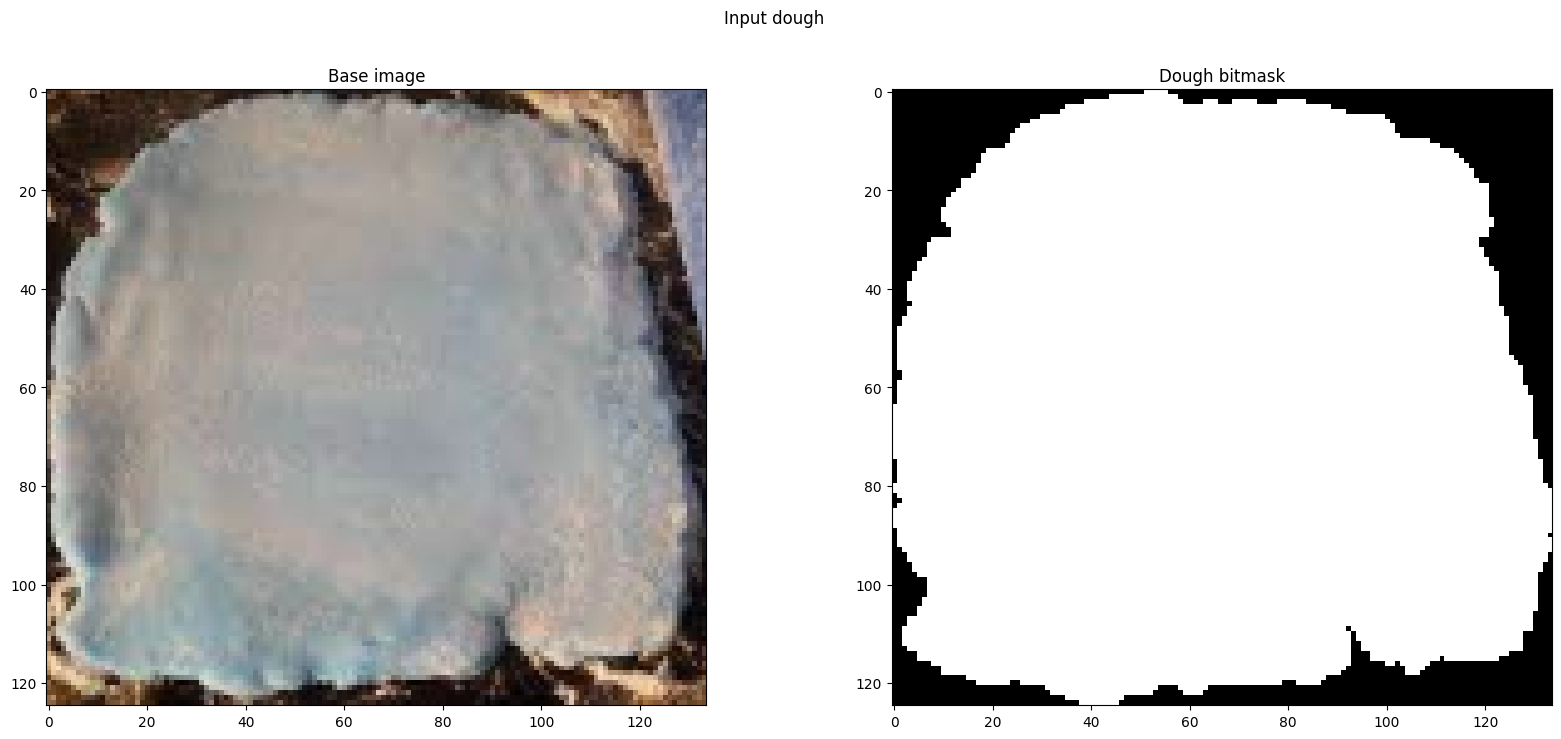

In [4]:
base_image, bitmask = utils.subsample_base_image(base_image, bitmask, resize_factor=0.7, display=True)

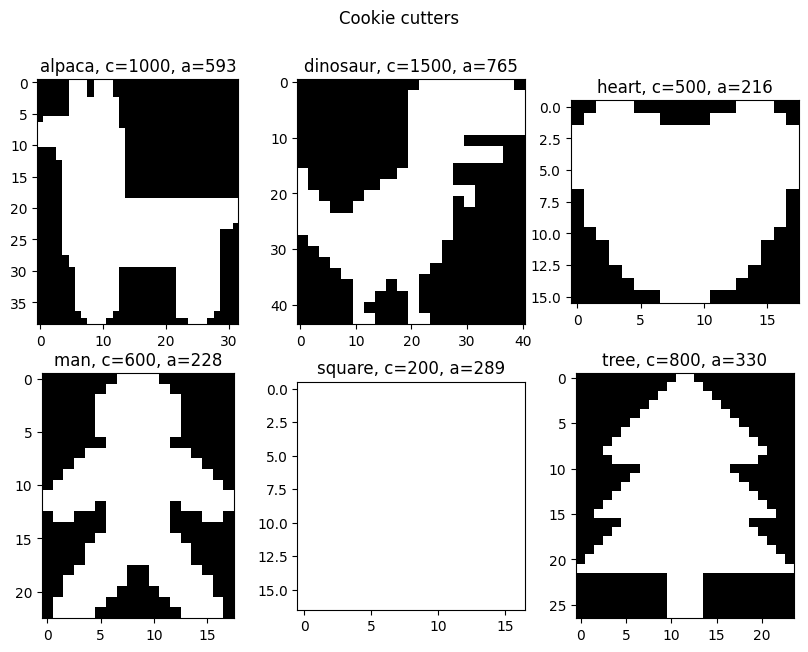

In [5]:
cutters = utils.load_cutters(cutters_path=os.path.join(images_dir, "cutters"), display=True)

## Model

In [6]:
model = gp.Model("biscuit_optimizer")

SETS

The problem's sets consist in:
- The set of available cutters $I$
- The set of rows of the input bitmask $N$
- The set of columns of the input bitmask $M$

In [18]:
I = list(range(len(cutters)))
N = list(range(bitmask.shape[0]))
M = list(range(bitmask.shape[1]))

print(f"I = {I}")
print(f"N = {N}")
print(f"M = {M}")

I = [0, 1, 2, 3, 4, 5]
N = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124]
M = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 11

PARAMETERS

The model's parameters consist in:
- The maximum number of rows and columns of the initial bitmask ($max\_N$ and $max\_M$)
- The initial bitmask ($binary\_mask$)
- The vectors for values ($\underline{c}$)
- The binary masks previously loaded 

In [20]:
max_N = max(N)
max_M = max(M)

binary_mask = np.where(bitmask, 1, 0)
c = [cutter['value'] for cutter in cutters]
a = [cutter['area'] for cutter in cutters]
B = np.count_nonzero(bitmask)

print(f"max_N = {max_N}")
print(f"max_M = {max_M}")
print(f"binary_mask shape: {binary_mask.shape}")
print(f"c = {c}")
print(f"a = {a}")
print("Cutters:")
for cutter in cutters:
	print(f"\t'{cutter['name']}' shape: {cutter['mask'].shape}")
print(f"B = {B}")

max_N = 124
max_M = 133
binary_mask shape: (125, 134)
c = [1000, 1500, 500, 600, 200, 800]
a = [593, 765, 216, 228, 289, 330]
Cutters:
	'alpaca' shape: (39, 32)
	'dinosaur' shape: (44, 41)
	'heart' shape: (16, 18)
	'man' shape: (23, 18)
	'square' shape: (17, 17)
	'tree' shape: (27, 24)
B = 13929


VARIABLES

The model variables are:
- $y$, binary variable over $I$, $N$ and $M$ corresponding to the top left corner of masks. $y_{n, m, i}$ is equal to 1 if mask $i$ has its top left corner in the $(n, m)$ coordinates of the input bitmask
- $z$, integer variable over $I$, $N$ and $M$ corresponding to the number of cutter masks $i \in I$ that cover the pixel $(n, m)$

In [11]:
y = model.addVars(len(N), len(M), len(I), vtype=GRB.BINARY, name="y")

In [12]:
z = model.addVars(len(N), len(M), len(I), lb=0, ub=B, vtype=GRB.INTEGER, name="z")

OBJECTIVE FUNCTION

The objective consists in maximizing the sum of the values of chosen biscuits

In [ ]:
model.setObjective(sum([sum([y[n, m, i] for n in N for m in M]) * c[i] for i in I]), GRB.MAXIMIZE)

CONSTRAINTS

The first set of constraints enforce that no $y$ that would produce an incomplete biscuit can be activated (this cell enforces both constraints using sets $IN_i$ and $OUT_i$ in the original model).

In [ ]:
for i in I:
	cutter_mask = cutters[i]['mask']
	for n in N:
		for m in M:
			if not utils.can_host(bitmask, cutter_mask, n, m):
				model.addConstr(y[n, m, i] == 0)

The next set of constraints links $z$ and $y$ variables. The cell prints the progress as these take some time.

In [17]:
for i in I:
	cutter_mask = cutters[i]['mask']
	print(f"{cutters[i]['name']} - shape {cutter_mask.shape}")
	for n in N:
		print(f"row {n}/{max_N}        ", end='\r')
		for m in M:	
			model.addConstr(z[n, m, i] == sum([y[n - l, m - o, i] * cutter_mask[l, o] 
				for l in range(cutter_mask.shape[0])
				for o in range(cutter_mask.shape[1]) 
				if n - l >= 0 and m - o >= 0]))
	print()

alpaca - shape (39, 32)
row 124/124        
dinosaur - shape (44, 41)
row 124/124        
heart - shape (16, 18)
row 124/124        
man - shape (23, 18)
row 124/124        
square - shape (17, 17)
row 124/124        
tree - shape (27, 24)
row 124/124        


Next, the set of non-overlapping constraints is defined. 

In [18]:
non_overlapping_contrs = model.addConstrs((sum([z[n, m, i] for i in I]) <= 1 for n in N for m in M))

Finally, the constraints for cutter frequency are added.

In [19]:
frequency_constrs = model.addConstrs((sum([y[n, m, i] for n in N for m in M]) <= 3 * sum([y[n, m, j] for n in N for m in M]) for i in I for j in I))

## Model solution

In [31]:
model.setParam('TimeLimit', 40000)
model.optimize()
print(f"Obj: {model.ObjVal}")

Set parameter TimeLimit to value 40000
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 166690 rows, 201000 columns and 33087380 nonzeros
Model fingerprint: 0x830e0396
Variable types: 0 continuous, 201000 integer (100500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [2e+02, 2e+03]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 72061 rows and 69168 columns (presolve time = 5s) ...
Presolve removed 72064 rows and 69168 columns (presolve time = 10s) ...
Presolve removed 85830 rows and 82934 columns (presolve time = 15s) ...
Presolve removed 85842 rows and 82934 columns (presolve time = 20s) ...
Presolve removed 85842 rows and 82934 columns (presolve time = 25s) ...
Presolve removed 85842 rows and 82934 columns (presolve time = 31s) ...
Presolve removed 85842 rows a

In [ ]:
solution = {i: [] for i in I}
for coords, var in y.items():
	if var.X > 0.0:
		solution[coords[2]].append((coords[0], coords[1]))

## Solution visualization

In [4]:
print("Solution:")
pprint(solution)

Solution:
{0: [(13, 64), (49, 40)],
 1: [(3, 31), (38, 82), (60, 2)],
 2: [(4, 33), (20, 11), (62, 2), (100, 110), (103, 6)],
 3: [(15, 103), (36, 3), (43, 54), (54, 111), (79, 29), (80, 49)],
 4: [(104, 28), (104, 45)],
 5: [(4, 78), (30, 18), (65, 68), (75, 107), (85, 86), (93, 63)]}


In [23]:
print(f'Cookie dough used = {round(sum([len(solution[i]) * a[i] for i in I]) / B * 100, 2)}%')

Cookie dough used = 60.93%


In [7]:
cutter_masks = {i: cutter["mask"] for i, cutter in enumerate(cutters)}

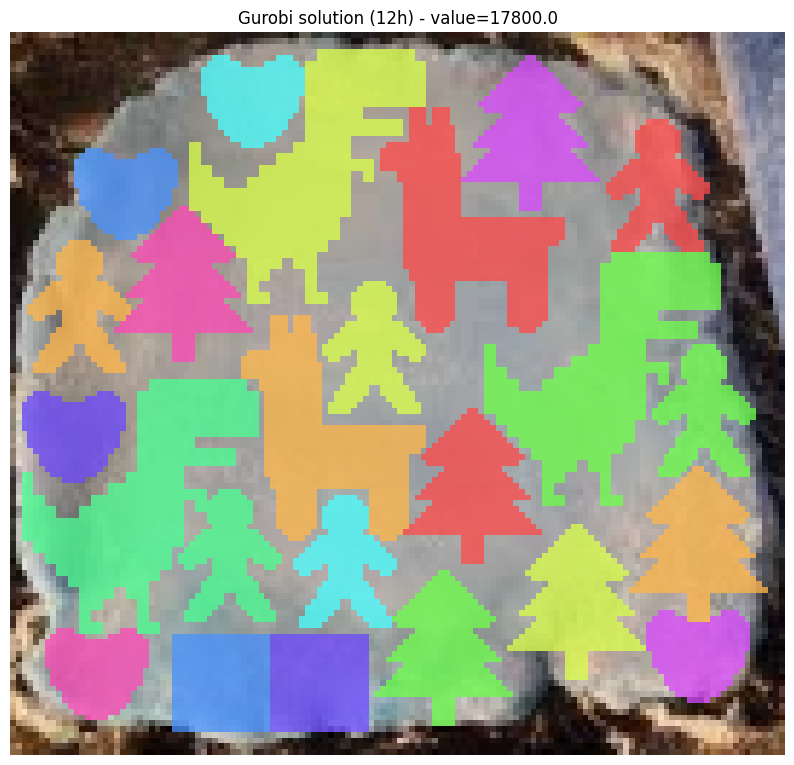

In [8]:
utils.show_cut_dough(base_image, cutter_masks, solution, title=f"Gurobi solution (12h) - value={model.ObjVal}")

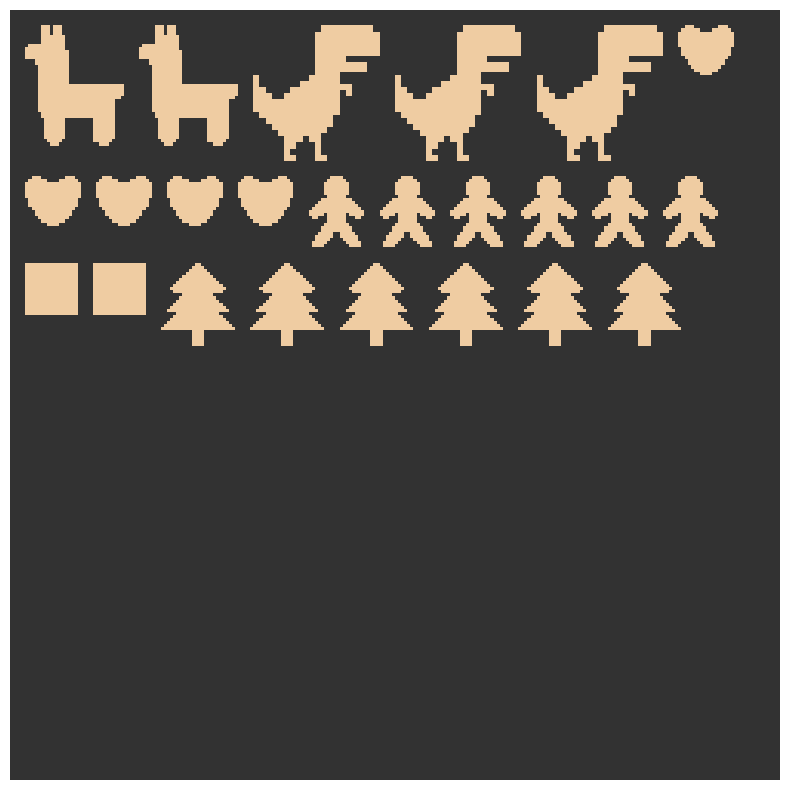

In [44]:
utils.show_pan(cutter_masks, {i: len(l) for i, l in solution.items()})